<a href="https://colab.research.google.com/github/meganm2c/MTC-SF-Neighborhood-Amenity-Equity-Project/blob/main/sf_acs_walkscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install census
!pip install us
from census import Census
from us import states
import os
import pandas as pd
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
import folium
import requests
from folium.features import GeoJson, GeoJsonTooltip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 8.8 MB/s eta 0:00:00


In [2]:
# Census API
from google.colab import userdata
censusAPIKey = Census(
    os.getenv(
        userdata.get('censusAPIKey')
        ))

In [3]:
#ACS Variables
variables = (
    "NAME",
    "B03002_001E",  # total population
    "B03002_003E",  # non-hispanic white
    "B19083_001E",  # gini index
    "B19013_001E",  # median income
    "B17001_001E",  # poverty denominator
    "B17001_002E",  # poverty count
    "B08301_010E"   # public transit commuters
)
acs_years = [2015, 2018, 2020, 2022, 2023]

#helper to filter for valid tracts only
def clean_sf_tracts(df):
    df["tract"] = df["tract"].astype(str).str.zfill(6)
    df["population_total"] = pd.to_numeric(df["population_total"], errors="coerce")
    df = df[df["population_total"] > 0]
    #remove water/Farallon/military
    df = df[~df["tract"].str.startswith(("98", "99"))]
    return df

sf_acs_year_dfs = []
for YEAR in acs_years:
  sf_acs = censusAPIKey.acs5.state_county_tract(
      variables,
      "06",      # CA
      "075",     # SF County
      Census.ALL,
      year = YEAR #looping through acs_years
  )

  sf_acs_df = pd.DataFrame(sf_acs)
  sf_acs_df["GEOID"] = sf_acs_df["state"] + sf_acs_df["county"] + sf_acs_df["tract"]

  #W6_S1 Converting GEOID to String (best practice)
  sf_acs_df["GEOID"] = sf_acs_df["GEOID"].astype(str)

  #renaming columns
  sf_acs_df = sf_acs_df.rename(columns={
      "B03002_001E": "population_total",
      "B03002_003E": "white/non_hispanic",
      "B19083_001E": "gini_index",
      "B19013_001E": "median_income",
      "B17001_001E": "poverty_denominator",
      "B17001_002E": "poverty_count",
      "B08301_010E": "transit_commuters"
  })
  #year column
  sf_acs_df["year"] = YEAR
  #deriving columns
  sf_acs_df["%_white_nonhisp"] = sf_acs_df["white/non_hispanic"] / sf_acs_df["population_total"]
  sf_acs_df["poverty_rate"] = sf_acs_df["poverty_count"] / sf_acs_df["poverty_denominator"]
  sf_acs_clean = clean_sf_tracts(sf_acs_df)
  sf_acs_year_dfs.append(sf_acs_clean)

final_sf_acs_years_panel = pd.concat(sf_acs_year_dfs, ignore_index=True)
final_sf_acs_years_panel

,NAME,population_total,white/non_hispanic,gini_index,median_income,poverty_denominator,poverty_count,transit_commuters,state,county,tract,GEOID,year,%_white_nonhisp,poverty_rate
0,"Census Tract 260.04, San Francisco County, Cal...",5015.0,528.0,0.4582,65862.0,5015.0,456.0,1099.0,06,075,026004,06075026004,2015,0.105284,0.090927
1,"Census Tract 301.01, San Francisco County, Cal...",4895.0,2915.0,0.4959,79071.0,4735.0,583.0,1326.0,06,075,030101,06075030101,2015,0.595506,0.123126
2,"Census Tract 330, San Francisco County, Califo...",8227.0,2891.0,0.4607,82527.0,8162.0,1088.0,1093.0,06,075,033000,06075033000,2015,0.351404,0.133301
3,"Census Tract 254.03, San Francisco County, Cal...",5154.0,1168.0,0.4495,73159.0,5128.0,611.0,1018.0,06,075,025403,06075025403,2015,0.226620,0.119150
4,"Census Tract 264.01, San Francisco County, Cal...",3937.0,137.0,0.4317,46150.0,3937.0,501.0,624.0,06,075,026401,06075026401,2015,0.034798,0.127254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,Census Tract 615.04; San Francisco County; Cal...,2133.0,390.0,0.4771,249539.0,2033.0,21.0,142.0,06,075,061504,06075061504,2023,0.182841,0.010330
1084,Census Tract 615.05; San Francisco County; Cal...,1162.0,291.0,0.2929,250001.0,1162.0,8.0,98.0,06,075,061505,06075061505,2023,0.250430,0.006885
1085,Census Tract 615.06; San Francisco County; Cal...,4918.0,1874.0,0.3948,250001.0,4918.0,174.0,285.0,06,075,061506,06075061506,2023,0.381049,0.035380
1086,Census Tract 615.07; San Francisco County; Cal...,1550.0,401.0,0.4970,167785.0,1539.0,60.0,436.0,06,075,061507,06075061507,2023,0.258710,0.038986


The Gini index measures income inequality within a census tract, where 0 represents perfect equality and 1 represents maximum inequality

In [4]:
gini_df = final_sf_acs_years_panel.copy()
gini_df["gini_index"] = pd.to_numeric(gini_df["gini_index"], errors="coerce")

mean_gini = gini_df.groupby("year", as_index=False)["gini_index"].mean()

fig = px.line(
    mean_gini,
    x="year",
    y="gini_index",
    markers=True,
    title="Trend in Mean Gini Index Over Time",
    labels={"gini_index": "Gini Index"}
)

fig.update_layout(template="plotly_white")
fig.show()


In [5]:
gini_df1 = final_sf_acs_years_panel.copy()
gini_df1["gini_index"] = pd.to_numeric(gini_df1["gini_index"], errors="coerce")
gini_df1["year"] = gini_df1["year"].astype(str)

fig = px.histogram(
    gini_df1,
    x="gini_index",
    animation_frame="year",
    nbins=20,
    title="Distribution of Gini Index Across Years",
    labels={"gini_index": "Gini Index"}
)

fig.update_layout(template="plotly_white")
fig.show()



In [6]:
#Creating an sf acs variable codebook
codebook_dir = Path("sf_acs_variable_codebook")
codebook_dir.mkdir(parents=True, exist_ok=True)


tracking = {
    "variable_name": [
        "pop_total", "white_nonhisp", "pct_white_nonhisp",
        "gini", "median_income",
        "poverty_denom", "poverty_count", "poverty_rate",
        "transit_commuters"
    ],
    "acs_code": [
        "B03002_001E", "B03002_003E", "derived",
        "B19083_001E", "B19013_001E",
        "B17001_001E", "B17001_002E", "derived",
        "B08301_010E"
    ],
    "description": [
        "Total population",
        "White Non-Hispanic (count)",
        "White Non-Hispanic proportion",
        "Income inequality (0–1)",
        "Median household income",
        "Poverty denominator",
        "Poverty count",
        "Poverty rate",
        "Workers commuting by public transit"
    ],
    "why_needed": [
        "Normalization denominator for all per-capita amenity metrics",
        "Demographic composition (race)",
        "Key racial equity variable",
        "Income inequality metric for regressions",
        "Economic stratification and control variable",
        "Required for poverty rate",
        "Required for poverty rate",
        "Socioeconomic covariate (SES)",
        "Commute access proxy (accessibility indicator)"
    ]
}

acs_codebook = pd.DataFrame(tracking)

# CSV
csv_path = codebook_dir / "sf_acs_variable_codebook.csv"
acs_codebook.to_csv(csv_path, index=False)

# Markdown (maybe add to report?)
md_path = codebook_dir / "sf_acs_variable_codebook.md"
acs_codebook.to_markdown(md_path, index=False)

csv_path, md_path

(PosixPath('sf_acs_variable_codebook/sf_acs_variable_codebook.csv'),
 PosixPath('sf_acs_variable_codebook/sf_acs_variable_codebook.md'))

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME_x',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry', 'NAME_y', 'population_total',
       'white/non_hispanic', 'gini_index', 'median_income',
       'poverty_denominator', 'poverty_count', 'transit_commuters', 'state',
       'county', 'tract', 'year', '%_white_nonhisp', 'poverty_rate'],
      dtype='object')


<Axes: >

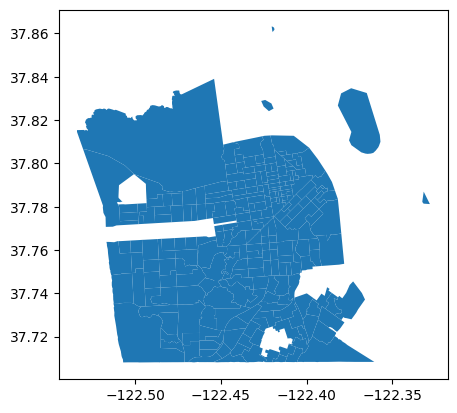

In [7]:
#San Francisco Tract Geometries
caTracts = gpd.read_file(
    f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"
)
sf_census_gdf = caTracts.merge(final_sf_acs_years_panel, on='GEOID', how='right')
print(sf_census_gdf.columns)

#Geometry ONLY (no time series)
sf_geom_only = sf_census_gdf.drop_duplicates("GEOID")[["GEOID", "geometry"]]
sf_geom_only.plot()


In [8]:
#Computing centroid and lat/lon for sf tracts to work with walkscore API
sf_geom_only["centroid"] = sf_geom_only.geometry.centroid
sf_geom_only["centroid_lat"] = sf_geom_only.centroid.y
sf_geom_only["centroid_lon"] = sf_geom_only.centroid.x


walkscoreAPIKey = userdata.get('walkscoreAPI')


#Walkscore API request func
def get_walkscore(lat, lon, api_key):
    url = "https://api.walkscore.com/score"
    params = {
        "lat": lat,
        "lon": lon,
        "address": f"{lat},{lon}",
        "transit": 1,
        "bike": 1,
        "format": "json",
        "wsapikey": walkscoreAPIKey
    }
    try:
        r = requests.get(url, params=params, timeout=5)
        data = r.json()
        return {
            "walkscore": data.get("walkscore"),
            "transit_score": data.get("transit", {}).get("score"),
            "bike_score": data.get("bike", {}).get("score"),
            "status": data.get("status")
        }
    except Exception:
        return {"walkscore": None, "transit_score": None, "bike_score": None, "status": None}

#Getting walkscore for each GEOID
walkscore_results = []

for _, row in sf_geom_only.iterrows():
    ws = get_walkscore(row["centroid_lat"], row["centroid_lon"], walkscoreAPIKey)
    ws["GEOID"] = row["GEOID"]
    walkscore_results.append(ws)

walkscore_df = pd.DataFrame(walkscore_results)
walkscore_df

/tmp/ipython-input-4121513993.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-4121513993.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-4121513993.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,walkscore,transit_score,bike_score,status,GEOID
0,91.0,83.0,53.0,1.0,06075026004
1,95.0,67.0,67.0,1.0,06075030101
2,NaN,NaN,NaN,30.0,06075033000
3,78.0,79.0,66.0,1.0,06075025403
4,70.0,67.0,47.0,1.0,06075026401
...,...,...,...,...,...
270,89.0,100.0,61.0,1.0,06075061504
271,94.0,100.0,73.0,1.0,06075061505
272,93.0,100.0,60.0,1.0,06075061506
273,94.0,100.0,81.0,1.0,06075061507


In [9]:
#Merging walk score with time series SF Tract ACS dataframe
sf_acs_years_with_walkscore = final_sf_acs_years_panel.merge(walkscore_df, on="GEOID", how="left")
sf_acs_years_with_walkscore.head()


,NAME,population_total,white/non_hispanic,gini_index,median_income,poverty_denominator,poverty_count,transit_commuters,state,county,tract,GEOID,year,%_white_nonhisp,poverty_rate,walkscore,transit_score,bike_score,status
0,"Census Tract 260.04, San Francisco County, Cal...",5015.0,528.0,0.4582,65862.0,5015.0,456.0,1099.0,06,075,026004,06075026004,2015,0.105284,0.090927,91.0,83.0,53.0,1.0
1,"Census Tract 301.01, San Francisco County, Cal...",4895.0,2915.0,0.4959,79071.0,4735.0,583.0,1326.0,06,075,030101,06075030101,2015,0.595506,0.123126,95.0,67.0,67.0,1.0
2,"Census Tract 330, San Francisco County, Califo...",8227.0,2891.0,0.4607,82527.0,8162.0,1088.0,1093.0,06,075,033000,06075033000,2015,0.351404,0.133301,NaN,NaN,NaN,30.0
3,"Census Tract 254.03, San Francisco County, Cal...",5154.0,1168.0,0.4495,73159.0,5128.0,611.0,1018.0,06,075,025403,06075025403,2015,0.226620,0.119150,78.0,79.0,66.0,1.0
4,"Census Tract 264.01, San Francisco County, Cal...",3937.0,137.0,0.4317,46150.0,3937.0,501.0,624.0,06,075,026401,06075026401,2015,0.034798,0.127254,70.0,67.0,47.0,1.0


In [10]:
# 1) Quick structure scan
sf_acs_years_with_walkscore.head()
sf_acs_years_with_walkscore.tail()
sf_acs_years_with_walkscore.sample(5)
sf_acs_years_with_walkscore.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NAME                 1088 non-null   object 
 1   population_total     1088 non-null   float64
 2   white/non_hispanic   1088 non-null   float64
 3   gini_index           1088 non-null   float64
 4   median_income        1088 non-null   float64
 5   poverty_denominator  1088 non-null   float64
 6   poverty_count        1088 non-null   float64
 7   transit_commuters    1088 non-null   float64
 8   state                1088 non-null   object 
 9   county               1088 non-null   object 
 10  tract                1088 non-null   object 
 11  GEOID                1088 non-null   object 
 12  year                 1088 non-null   int64  
 13  %_white_nonhisp      1088 non-null   float64
 14  poverty_rate         1088 non-null   float64
 15  walkscore            1001 non-null   f

In [11]:
sf_acs_years_with_walkscore.columns
sf_acs_years_with_walkscore.columns = (
    sf_acs_years_with_walkscore.columns
      .str.strip()
      .str.lower()
      .str.replace(r'[^0-9a-z_]', '_', regex=True)
)

sf_acs_years_with_walkscore.columns
sf_acs_years_with_walkscore["percent_white_nonhisp"] = sf_acs_years_with_walkscore["__white_nonhisp"]


In [12]:
# Index should be unique
sf_acs_years_with_walkscore.index.is_unique


True

In [13]:
sf_acs_years_with_walkscore.duplicated().sum()


np.int64(0)

In [14]:
sf_acs_years_with_walkscore.isnull().sum().sort_values(ascending=False)


,0
transit_score,95
walkscore,87
bike_score,87
status,9
gini_index,0
white_non_hispanic,0
population_total,0
name,0
median_income,0
poverty_denominator,0


Missing data in my project is not just a technical issue but a real reminder of what David J. Hand calls “dark data,” which pushes me to think about why some information never shows up in the first place. When certain tracts have no WalkScore or no transit data it is not random but a clue that these areas may be isolated or shaped by decisions that never get recorded. Instead of treating these gaps as simple errors I have to see them as part of the story because they affect how people move live and access resources. This makes me more cautious and more aware that my results reflect what is visible while the invisible parts still influence the city.

In [15]:
missing_ws = sf_acs_years_with_walkscore[sf_acs_years_with_walkscore["walkscore"].isna()]
missing_ws[["geoid", "population_total", "year"]].sort_values("population_total")
missing_ws.head()

,name,population_total,white_non_hispanic,gini_index,median_income,poverty_denominator,poverty_count,transit_commuters,state,county,tract,geoid,year,__white_nonhisp,poverty_rate,walkscore,transit_score,bike_score,status,percent_white_nonhisp
2,"Census Tract 330, San Francisco County, Califo...",8227.0,2891.0,0.4607,82527.0,8162.0,1088.0,1093.0,06,075,033000,06075033000,2015,0.351404,0.133301,NaN,NaN,NaN,30.0,0.351404
11,"Census Tract 207, San Francisco County, Califo...",5553.0,3642.0,0.4827,127798.0,5553.0,673.0,1831.0,06,075,020700,06075020700,2015,0.655862,0.121196,NaN,NaN,NaN,30.0,0.655862
12,"Census Tract 208, San Francisco County, Califo...",6302.0,2051.0,0.5444,67295.0,6302.0,972.0,1787.0,06,075,020800,06075020800,2015,0.325452,0.154237,NaN,NaN,NaN,30.0,0.325452
16,"Census Tract 107, San Francisco County, Califo...",5302.0,1133.0,0.6054,22260.0,5302.0,1379.0,796.0,06,075,010700,06075010700,2015,0.213693,0.260091,NaN,NaN,NaN,30.0,0.213693
20,"Census Tract 101, San Francisco County, Califo...",3798.0,1787.0,0.5391,61442.0,3779.0,589.0,478.0,06,075,010100,06075010100,2015,0.470511,0.155861,NaN,NaN,NaN,30.0,0.470511


In [16]:
missing_ws["status"].value_counts(dropna=False)


,count
status,
30.0,78
NaN,9


Some tracts came back with an invalid latitude and longitude because their centroids land in spots like water or industrial edges where Walk Score will not calculate anything. I am keeping these tracts in the dataset since people still live in some of them and removing them would quietly distort the patterns we are trying to measure.

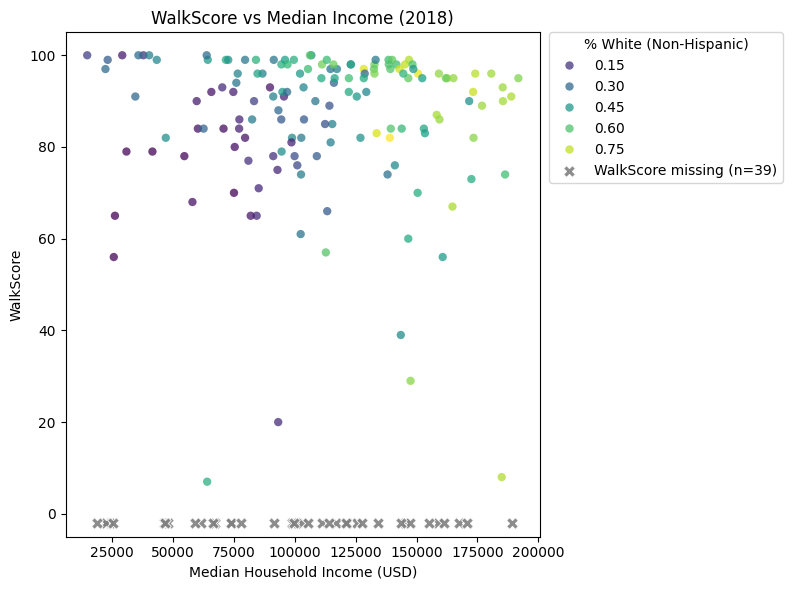

In [17]:
sf_2018 = sf_acs_years_with_walkscore.query("year == 2018").copy()
sf_2018["median_income"] = pd.to_numeric(sf_2018["median_income"], errors="coerce")
sf_2018 = sf_2018[sf_2018["median_income"].between(10_000, 300_000)]

valid_18   = sf_2018[sf_2018["walkscore"].notna()].copy()
missing_18 = sf_2018[sf_2018["walkscore"].isna()].copy().assign(walkscore=-2)

fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(
    data=valid_18,
    x="median_income",
    y="walkscore",
    hue="percent_white_nonhisp",
    palette="viridis",
    alpha=0.75,
    edgecolor="none",
    ax=ax
)

sns.scatterplot(
    data=missing_18,
    x="median_income",
    y="walkscore",
    marker="X",
    color="gray",
    s=70,
    label=f"WalkScore missing (n={len(missing_18)})",
    alpha=0.9,
    ax=ax
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    title="% White (Non-Hispanic)",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.0,
    frameon=True
)
plt.tight_layout(rect=[0, 0, 0.85, 1])

ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("WalkScore")
ax.set_title("WalkScore vs Median Income (2018)")
ax.set_ylim(-5, 105)

plt.tight_layout()

outdir = Path("visualizations")
outdir.mkdir(parents=True, exist_ok=True)
outfile = outdir / "walkscore_vs_income_2018_race.png"
fig.savefig(outfile, dpi=300, bbox_inches="tight")
plt.show()

In [18]:
df_2018 = sf_acs_years_with_walkscore.query("year == 2018").copy()

# Ensure correct numeric type
df_2018["median_income"] = pd.to_numeric(df_2018["median_income"], errors="coerce")

# Split groups
valid_2018   = df_2018[df_2018["walkscore"].notna()]
missing_2018 = df_2018[df_2018["walkscore"].isna()]

# Averages
mean_valid_2018   = valid_2018["median_income"].mean()
mean_missing_2018 = missing_2018["median_income"].mean()

mean_valid_2018, mean_missing_2018
summary_2018 = df_2018.groupby(df_2018["walkscore"].isna()).agg(
    mean_income=("median_income", "mean"),
    std_income=("median_income", "std"),
    n=("median_income", "count")
)

summary_2018.index = ["valid_walkscore", "missing_walkscore"]
summary_2018

,mean_income,std_income,n
valid_walkscore,109819.377483,41308.236220,151
missing_walkscore,98618.769231,46884.762808,39


Tracts without WalkScores in 2018 have a slightly lower average median household income than tracts with valid WalkScores, but the difference is not dramatic

In [19]:


#oopsies should probably fix
sf_geom_only = sf_geom_only.rename(columns={"GEOID": "geoid"})
sf_2022 = sf_acs_years_with_walkscore.query("year == 2022").copy()

# Merge ACS attributes into geometry
sf_map = sf_geom_only.merge(
    sf_2022[["geoid", "transit_score", "walkscore", "bike_score",
             "median_income", "poverty_rate", "percent_white_nonhisp"]],
    on="geoid",
    how="left"
).dropna(subset=["geometry"])

# Drop the 'centroid' column as it's not JSON serializable and not needed for the map
sf_map = sf_map.drop(columns=["centroid"])

#Base map
m = folium.Map(
    location=[37.76, -122.45],
    zoom_start=12,
    tiles="CartoDB Positron"
)

#Transit score chloropleth
folium.Choropleth(
    geo_data=sf_map.to_json(),
    data=sf_map,
    columns=["geoid", "transit_score"],
    key_on="feature.properties.geoid",
    fill_color="YlGnBu",
    fill_opacity=0.85,
    line_opacity=0.3,
    nan_fill_color="lightgray",
    legend_name="Transit Score (WalkScore Transit API)"
).add_to(m)

# Hover tooltip layer
GeoJson(
    sf_map.to_json(),
    name="Census Tracts",
    tooltip=GeoJsonTooltip(
        fields=["geoid", "transit_score", "median_income", "poverty_rate", "percent_white_nonhisp"],
        aliases=["GEOID", "Transit Score", "Median Income", "Poverty Rate", "% White (Non-Hispanic)"],
        sticky=False
    ),
    style_function=lambda _feat: {"fillOpacity": 0, "color": "transparent"}
).add_to(m)
outdir = Path("visualizations")
outdir.mkdir(exist_ok=True)
outfile = outdir / "sf_transit_choropleth_2022.html"
m.save(outfile)
m